In [1]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [2]:
pip install graphviz

In [3]:
## Import from the future
from __future__ import absolute_import, division, print_function

## TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import model_to_dot, plot_model
from keras_tuner import HyperModel, RandomSearch, Objective

## "Normal" libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (auc, precision_recall_curve, confusion_matrix,
                             roc_auc_score, roc_curve, classification_report,
                             precision_score, recall_score, f1_score, accuracy_score,
                             roc_curve, auc)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from IPython.display import SVG
from sklearn.linear_model import LogisticRegression


In [4]:
def unique_value_counts(array):
    array = np.array(array)  # Convert to numpy array if not already
    unique, counts = np.unique(array, return_counts=True)
    return dict(zip(unique, counts))

In [5]:
def calculate_metrics(y_true, y_pred, y_prob=None, metrics=['precision', 'recall', 'f1', 'accuracy', 'auc']):
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    TP = cm[1, 1]
    FP = cm[0, 1]
    TN = cm[0, 0]
    FN = cm[1, 0]

    results = {}

    # Calculate precision
    if 'precision' in metrics:
        results['precision'] = round( TP / (TP + FP), 4) if (TP + FP) > 0 else 0

    # Calculate recall
    if 'recall' in metrics:
        results['recall'] = round( TP / (TP + FN), 4) if (TP + FN) > 0 else 0

    # Calculate F1 score
    if 'f1' in metrics:
        results['f1'] = round( 2 * (TP / (2 * TP + FP + FN)), 4) if (2 * TP + FP + FN) > 0 else 0

    # Calculate accuracy
    if 'accuracy' in metrics:
        results['accuracy'] = round( (TP + TN) / (TP + TN + FP + FN), 4)

    # Calculate AUC
    if 'auc' in metrics and y_prob is not None:
        # Note: AUC requires probabilities, not class labels.
        results['auc'] = round( roc_auc_score(y_true, y_prob), 4)

    return results


# Data set-up

In [6]:
# Load the dataset
data = pd.read_excel('cleaned data.xlsx')

# Save as dataframe
data = pd.DataFrame(data)

In [7]:
# create X (features) and y (response)
X = data.drop(['Pno', 'Take-up ind'], axis = 1)
y = data['Take-up ind']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# all my variables as seen as floats rather than strings or integers
X = X.astype(np.float32).values
y = y.astype(np.float32).values

In [8]:
# Get the test set (10%)
x_train_val, x_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=7)

# Now training (70%) and validation sets (20%)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_val, y_train_val, test_size=0.2222, stratify=y_train_val, random_state=7)

# Apply SMOTE to the training data
smote = SMOTE(random_state=7)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)

# Calculate class weights to ensure equal 1:1
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train_smote),
    y=y_train_smote)
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)

{0: 1.0, 1: 1.0}


# Version 1 - UNWEIGHTED CLASSES, NO SMOTE

In [9]:
# Build
model = keras.Sequential([
    keras.layers.Input(shape=(25,)),                # Number of input features
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')     # Single output unit for binary classification
])


# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(), 'accuracy', 'Precision', 'Recall'])


# Fit and train
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=0)


In [10]:
# Predict
y_probs = model.predict(x_train)
y_train_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_train_pred))

# Metrics
metrics = calculate_metrics(y_true=y_train, y_pred=y_train_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
{0: 765}
{'precision': 0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9046, 'auc': 0.4832}


In [11]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
{0: 219}
{'precision': 0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9041, 'auc': 0.4815}


# VERSION 2 - CLASSES WEIGHTED, NO SMOTE

In [12]:
# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict_v2 = dict(enumerate(class_weights))
class_weight_dict_v2

{0: 0.5527456647398844, 1: 5.239726027397261}

In [41]:
# Build
model = keras.Sequential([
    keras.layers.Input(shape=(25,)),                # Number of input features
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')     # Single output unit for binary classification
])


# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(), 'accuracy', 'Precision', 'Recall'])


# Fit and train
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), verbose=0, class_weight=class_weight_dict_v2)

In [42]:
# Predict
y_probs = model.predict(x_train)
y_train_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_train_pred))

# Metrics
metrics = calculate_metrics(y_true=y_train, y_pred=y_train_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
{0: 474, 1: 291}
{'precision': 0.1203, 'recall': 0.4795, 'f1': 0.1923, 'accuracy': 0.6157, 'auc': 0.5689}


In [43]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
{0: 148, 1: 71}
{'precision': 0.0986, 'recall': 0.3333, 'f1': 0.1522, 'accuracy': 0.6438, 'auc': 0.5774}


# Version 3 - SMOTE

In [56]:
# Build
model = keras.Sequential([
    keras.layers.Input(shape=(25,)),                # Number of input features
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')     # Single output unit for binary classification
])


# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(), 'accuracy', 'Precision', 'Recall'])


# Fit and train
history = model.fit(x_train_smote, y_train_smote, validation_data=(x_val, y_val), verbose=0, class_weight=class_weight_dict)

In [57]:
# Predict
y_probs = model.predict(x_train_smote)
y_train_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_train_pred))
# Metrics
metrics = calculate_metrics(y_true=y_train_smote, y_pred=y_train_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
{0: 157, 1: 1227}
{'precision': 0.5395, 'recall': 0.9566, 'f1': 0.6899, 'accuracy': 0.5701, 'auc': 0.6351}


In [58]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
{0: 37, 1: 182}
{'precision': 0.1099, 'recall': 0.9524, 'f1': 0.197, 'accuracy': 0.2557, 'auc': 0.7169}


# HYPERPARAMETER TUNING

In [ ]:
def build_model(hp):
    model = keras.Sequential()

    # Tuning the number of layers
    for i in range(hp.Int('num_layers', 2, 3)):
        # Tuning the number of neurons in each layer
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i),
                         min_value=5,
                         max_value=80,
                         step=5),
            activation='relu'))

    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Tuning the learning rate for the optimizer
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')])

    return model


In [ ]:
# Define the tuner with an explicit objective
tuner = RandomSearch(
    build_model,
    objective=Objective("val_auc", direction="max"),
    max_trials=5,
    executions_per_trial=3,
    directory='my_dir',
    project_name='optimize_auc')

In [ ]:
tuner.search(x_train_smote, y_train_smote,
             epochs=10,
             validation_data=(x_val, y_val))


Trial 5 Complete [00h 00m 12s]
val_auc: 0.7323633233706156

Best val_auc So Far: 0.7366522351900736
Total elapsed time: 00h 01m 33s


In [ ]:
# Retrieve the hyperparameters for the top 5 models and extract accordingly
check_best_hps = tuner.get_best_hyperparameters(num_trials=5)[3]

# Build the  model
check_best_model = tuner.hypermodel.build(check_best_hps)

# Pass a batch of data
check_best_model(x_train_smote[:1])

# Inspect the model
check_best_model.summary()

# Optional: Evaluate the model
loss, auc = check_best_model.evaluate(x_val, y_val)
print(f"Val AUC for this model: {auc}")

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (1, 10)                   260       
                                                                 
 dense_23 (Dense)            (1, 20)                   220       
                                                                 
 dense_24 (Dense)            (1, 10)                   210       
                                                                 
 dense_25 (Dense)            (1, 1)                    11        
                                                                 
Total params: 701 (2.74 KB)
Trainable params: 701 (2.74 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
7/7 [==============================] - 0s 5ms/step - loss: 0.7397 - auc: 0.3797
Val AUC for this model: 0.3797498941421509


# Rebuild the best tuned and chosen model

In [59]:
# Build
model = keras.Sequential([
    keras.layers.Input(shape=(25,)),                # Number of input features
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(20, activation='relu'),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')     # Single output unit for binary classification
])


# Compile
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(), 'accuracy', 'Precision', 'Recall'])


# Fit and train
history = model.fit(x_train_smote, y_train_smote, epochs=10, validation_data=(x_val, y_val), verbose=0)

In [60]:
# Predict
y_probs = model.predict(x_train_smote)
y_train_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_train_pred))
# Metrics
metrics = calculate_metrics(y_true=y_train_smote, y_pred=y_train_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
{0: 599, 1: 785}
{'precision': 0.7592, 'recall': 0.8613, 'f1': 0.807, 'accuracy': 0.7941, 'auc': 0.8559}


In [ ]:
# Predict
y_probs = model.predict(x_val)
y_val_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_val_pred))

# Metrics
metrics = calculate_metrics(y_true=y_val, y_pred=y_val_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
{0: 170, 1: 49}
{'precision': 0.2041, 'recall': 0.4762, 'f1': 0.2857, 'accuracy': 0.7717, 'auc': 0.7143}


In [ ]:
# Predict
y_probs = model.predict(x_test)
y_test_pred = (y_probs > 0.5).astype(int) # Apply threshold
print(unique_value_counts(y_test_pred))

# Metrics
metrics = calculate_metrics(y_true=y_test, y_pred=y_test_pred, y_prob=y_probs,
                            metrics=['precision', 'recall', 'f1', 'accuracy', 'auc'])
print(metrics)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
{0: 79, 1: 31}
{'precision': 0.2258, 'recall': 0.7, 'f1': 0.3415, 'accuracy': 0.7545, 'auc': 0.735}


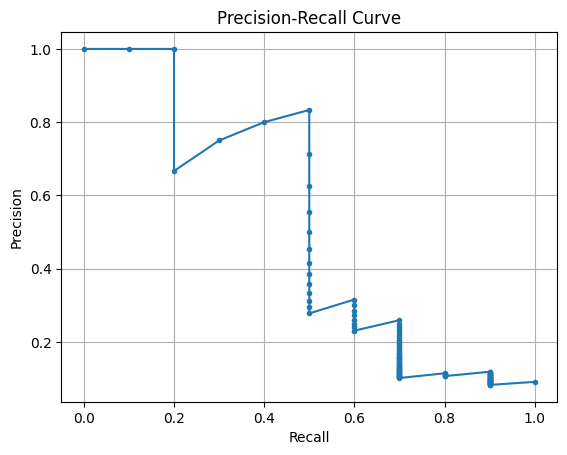

In [ ]:
# Compute precision and recall values
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

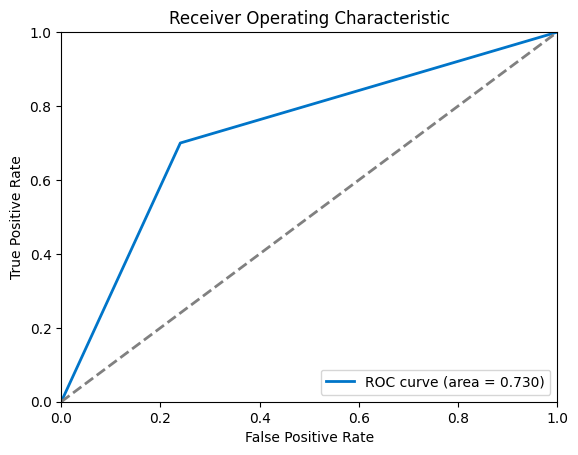

In [ ]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_test_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='#0075C9', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Baseline AUC: 0.7350000000000001
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 896us/step
Feature 0: Permuted AUC = 0.735, Importance = -1.1102230246251565e-16
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step
Feature 1: Permuted AUC = 0.736, Importance = 0.0009999999999998899
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature 2: Permuted AUC = 0.733, Importance = -0.002000000000000113
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature 3: Permuted AUC = 0.7770000000000001, Importance = 0.04200000000000004
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 930us/step
Feature 4: Permuted AUC = 0.716, Importance = -0.019000000000000128
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 706us/step
Feature 5: Permuted AUC = 0.714, Importance = -0.02100000000000013
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
Feature 6: Permuted AUC = 0.5820000000000001, Importance = -0.15300000000000002
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Feature 7: Permuted AUC = 0.7569999999999999, Importance = 0.021999999999999797
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
F

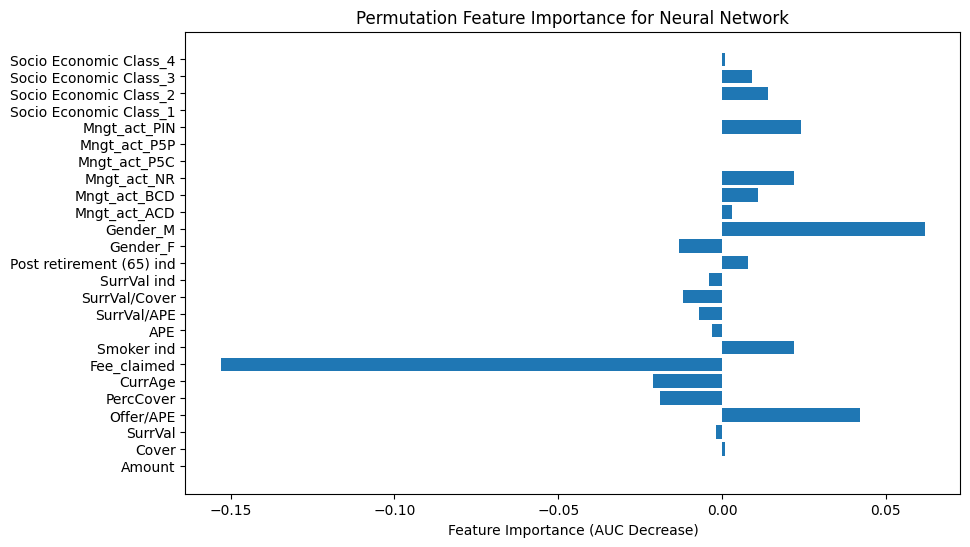

In [ ]:
# Function to compute permutation feature importance
def permutation_importance(model, x_test, y_test, metric=roc_auc_score):
    # Get baseline score
    y_pred = model.predict(x_test).flatten()
    baseline_score = metric(y_test, y_pred)
    print(f"Baseline AUC: {baseline_score}")

    feature_importance = []

    for col in range(x_test.shape[1]):
        X_permuted = x_test.copy()
        np.random.shuffle(X_permuted[:, col])
        y_pred_permuted = model.predict(X_permuted).flatten()
        permuted_score = metric(y_test, y_pred_permuted)
        importance = permuted_score - baseline_score
        feature_importance.append(importance)
        print(f"Feature {col}: Permuted AUC = {permuted_score}, Importance = {importance}")

    return np.array(feature_importance)

# Calculate permutation feature importance
feature_importance = permutation_importance(model, x_test, y_test)

# Plot the feature importance
feature_names = ['Amount', 'Cover', 'SurrVal', 'Offer/APE', 'PercCover', 'CurrAge',
       'Fee_claimed', 'Smoker ind', 'APE', 'SurrVal/APE', 'SurrVal/Cover',
       'SurrVal ind', 'Post retirement (65) ind', 'Gender_F', 'Gender_M',
       'Mngt_act_ACD', 'Mngt_act_BCD', 'Mngt_act_NR', 'Mngt_act_P5C',
       'Mngt_act_P5P', 'Mngt_act_PIN', 'Socio Economic Class_1',
       'Socio Economic Class_2', 'Socio Economic Class_3',
       'Socio Economic Class_4']

plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance (AUC Decrease)')
plt.title('Permutation Feature Importance for Neural Network')
plt.show()

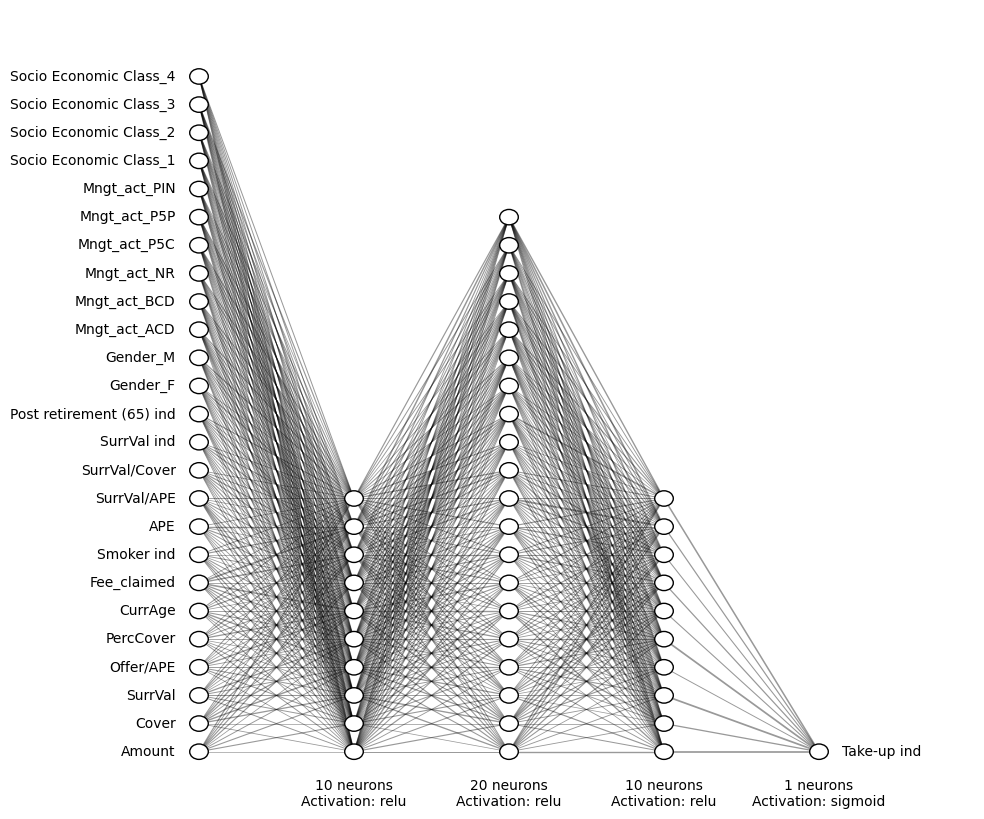

In [ ]:
# Function to draw neurons
def draw_neuron(ax, position, size=0.01, label=None, label_position='left', fontsize=10):
    circle = plt.Circle(position, size, edgecolor='black', facecolor='white', zorder=2)
    ax.add_artist(circle)
    if label:
        if label_position == 'left':
            ax.text(position[0] - size * 2.5, position[1], label, fontsize=fontsize, ha='right', va='center', zorder=3)
        elif label_position == 'right':
            ax.text(position[0] + size * 2.5, position[1], label, fontsize=fontsize, ha='left', va='center', zorder=3)
        else:
            ax.text(position[0], position[1], label, fontsize=fontsize, ha='center', va='center', zorder=3)

# Function to draw connections with thinner lines
def draw_connection(ax, p1, p2, weight, color='black'):
    linewidth = 0.5 + abs(weight)  # Adjust this value to make the lines thinner
    line = plt.Line2D((p1[0], p2[0]), (p1[1], p2[1]), linewidth=linewidth, color=color, zorder=1, alpha=0.4)
    ax.add_artist(line)



# Function to visualize the neural network
def visualize_nn(model, input_labels=None, output_label='y'):
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

    # Define positions of neurons
    layer_sizes = [layer.input_shape[-1] for layer in model.layers] + [model.layers[-1].units]
    v_spacing = 0.95 / (max(layer_sizes) + 1)
    h_spacing = 1.0 / (len(layer_sizes) + 1)

    neuron_positions = []
    for i, layer_size in enumerate(layer_sizes):
        neuron_positions.append([])
        layer_x = h_spacing * (i + 1)
        for j in range(layer_size):
            neuron_positions[-1].append((layer_x, v_spacing * (j + 1)))

    # Draw neurons with labels
    for i, layer in enumerate(neuron_positions):
        for j, neuron in enumerate(layer):
            if i == 0 and input_labels:  # Input layer
                label = input_labels[j]
                draw_neuron(ax, neuron, label=label, label_position='left', fontsize=10)
            elif i == len(neuron_positions) - 1:  # Output layer
                label = output_label
                draw_neuron(ax, neuron, label=label, label_position='right', fontsize=10)
            else:
                draw_neuron(ax, neuron)

    # Draw connections
    for i, (layer1, layer2) in enumerate(zip(neuron_positions[:-1], neuron_positions[1:])):
        weights, _ = model.layers[i].get_weights()
        for j, neuron1 in enumerate(layer1):
            for k, neuron2 in enumerate(layer2):
                weight = weights[j, k]
                draw_connection(ax, neuron1, neuron2, weight)

    # Add layer info (number of neurons and activation function) below the layers
    for i, layer in enumerate(model.layers):
        layer_x = h_spacing * (i + 2)
        layer_info = f"{layer.units} neurons\nActivation: {layer.activation.__name__}"
        ax.text(layer_x, -v_spacing / 2, layer_info, fontsize=10, ha='center', va='center', zorder=3)

    plt.show()

# Define input labels
input_labels = ['Amount', 'Cover', 'SurrVal', 'Offer/APE', 'PercCover', 'CurrAge',
       'Fee_claimed', 'Smoker ind', 'APE', 'SurrVal/APE', 'SurrVal/Cover',
       'SurrVal ind', 'Post retirement (65) ind', 'Gender_F', 'Gender_M',
       'Mngt_act_ACD', 'Mngt_act_BCD', 'Mngt_act_NR', 'Mngt_act_P5C',
       'Mngt_act_P5P', 'Mngt_act_PIN', 'Socio Economic Class_1',
       'Socio Economic Class_2', 'Socio Economic Class_3',
       'Socio Economic Class_4']

# Visualize the model
visualize_nn(model, input_labels=input_labels, output_label='Take-up ind')


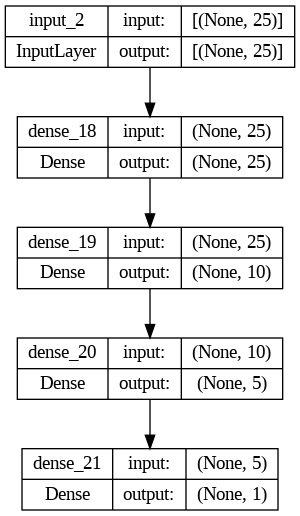

In [ ]:
# Plot the model
plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)